## 04-03 STN shard 0 leader: 18.237.207.112 when Seb's spamming

In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from IPython.core.display import display, HTML

In [2]:
def read_data(files, path, keyword):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file) as f:
                for line in f.readlines():
                    if keyword in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:%S.%f')
    df = df.sort_values(by='time').reset_index(drop = True)
    return df

In [4]:
def processing(data):
    df = pd.DataFrame(data, columns = ['blockNum', 'time', 'message'])
    df["message"] = df["message"].apply(lambda c: c.replace("-","").replace("=","").strip())
    df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:%S.%f')
    df.sort_values(by=['time','message'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

In [5]:
def get_block_change_index(df):
    df['block_diff'] = (df['blockNum']-df['blockNum'].shift()).fillna(0).astype(int)
    index = df[df['block_diff'] < 0].index.tolist()
    index.insert(0,0)
    index.append(len(df))
    return index

In [6]:
def aggregate_count(df, time, name):
    agg = df.groupby([pd.Grouper(freq= str(time) + 'Min', key = 'time'), name])[name].count().\
    reset_index(name = 'count')
    return agg

In [7]:
def aggregate_mean(df, time, name):
    agg = df.groupby([pd.Grouper(freq= str(time) + 'Min', key = 'time')])['size'].mean()\
    .reset_index(name = 'size')
    return agg

In [8]:
log_dir = "/home/ubuntu/jupyter/logs/stn/20/04/03/19:11:05/leader/tmp_log/log-20200403.121427/"
files = os.listdir(log_dir)
data = read_data(files, log_dir, 'receive p2p message')
df = data_processing(data)
# change size to KB
df['size'] = df['size']/1024

In [9]:
# import block processing time
data = read_data(files, log_dir, "PROPOSING NEW BLOCK")
data2 = read_data(files, log_dir, "Successfully Proposed New Block")
data.extend(data2)
propose = processing(data)
# there is a restart of the newtwork
index = get_block_change_index(propose)
lst = []
for idx in range(len(index)-1):
    new = propose.loc[index[idx]:index[idx+1]-1]
    new = new.drop_duplicates(subset = ['blockNum', 'message'], keep = "last")
    new['time_diff'] = new.groupby(['blockNum'])['time'].apply(lambda c: c.diff().dt.microseconds /1000000)
    lst.append(new)
proposing = pd.concat(lst)    
proposing.dropna(inplace = True)
proposing.reset_index(inplace = True, drop = True) 

In [10]:
data = read_data(files, log_dir, "Got more transactions")
transaction = data_processing(data)
tps = transaction.groupby([pd.Grouper(freq= '1s', key = 'time')])['totalQueued'].count().\
reset_index(name = 'tps')

### p2p message counts aggregate in 5 minutes

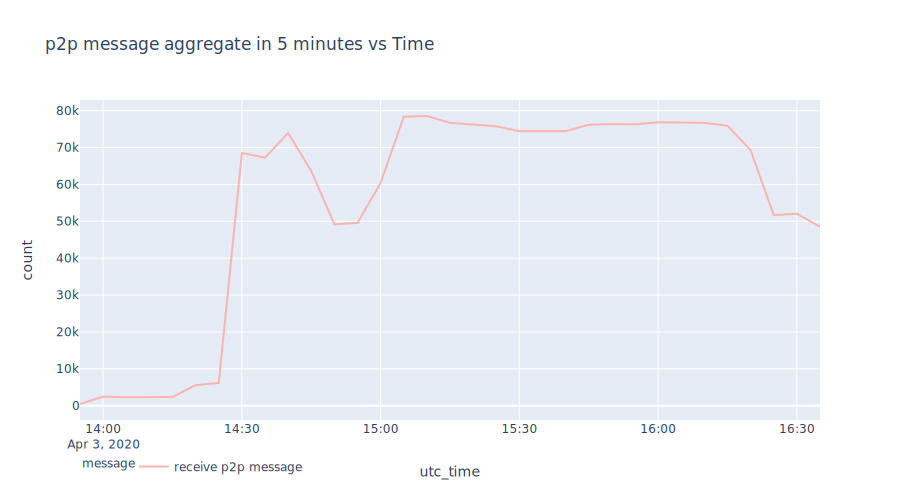

In [11]:
agg = aggregate_count(df, 5, 'message')
hover = agg.columns.tolist()
fig = px.line(agg, x="time", y="count", color='message', color_discrete_sequence=px.colors.qualitative.Pastel1, \
          title =  'p2p message aggregate in 5 minutes vs Time', hover_data=hover)
fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=0, y=-0.1))
fig.show(renderer="svg",width=900, height=500)

### size statistics

In [12]:
df["size"].describe().apply(lambda x: format(x, 'f'))

count    1819640.000000
mean          31.109609
std           21.761373
min            0.120117
25%           31.368164
50%           31.368164
75%           31.368164
max         1184.713867
Name: size, dtype: object

### size aggregate average in 5 minutes

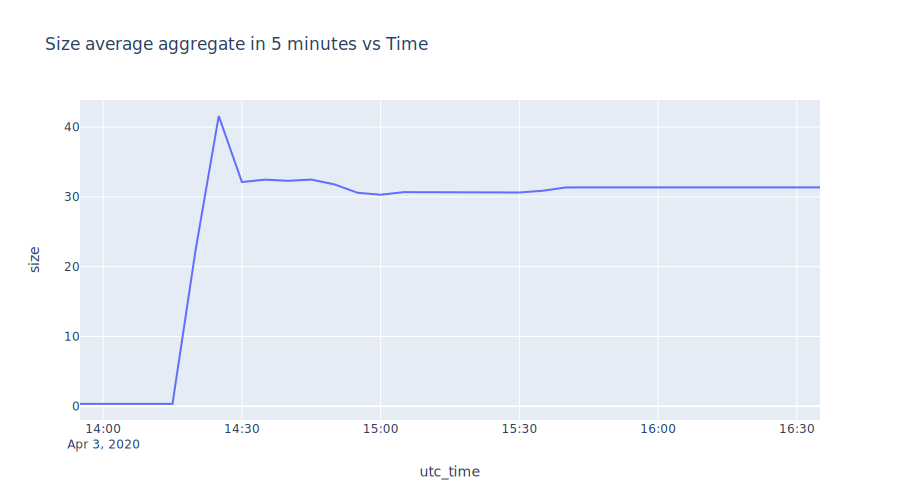

In [13]:
agg = aggregate_mean(df, 5, 'size')
fig = px.line(agg, x="time", y="size", title ='Size average aggregate in 5 minutes vs Time')
fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=0, y=-0.1))
fig.show(renderer="svg",width=900, height=500)

### size change vs time before spamming

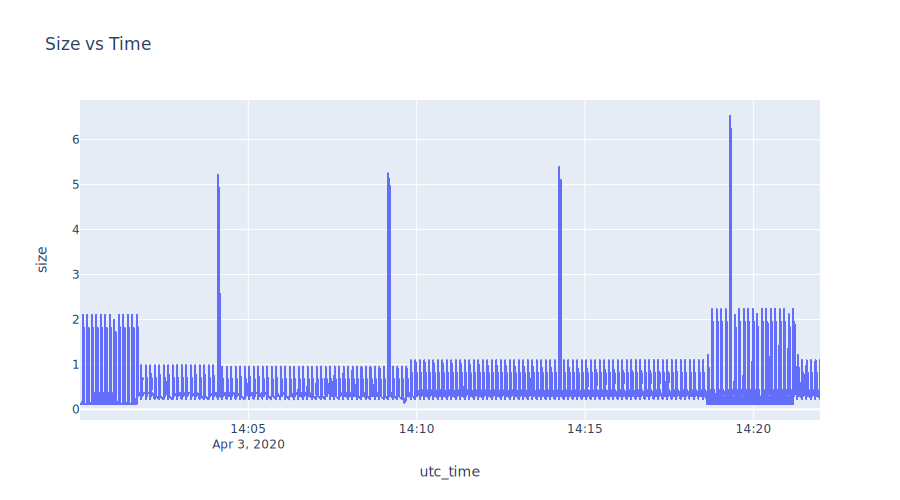

In [14]:
start_time = '2020-04-03 14:00:00.0'
end_time = '2020-04-03 14:22:00.0'
fig = px.line(df[(df['time'] < end_time) & (df['time'] > start_time)], x="time", y="size", title ='Size vs Time')
fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=0, y=-0.1))
fig.show(renderer="svg",width=900, height=500)

### size change vs time when spamming

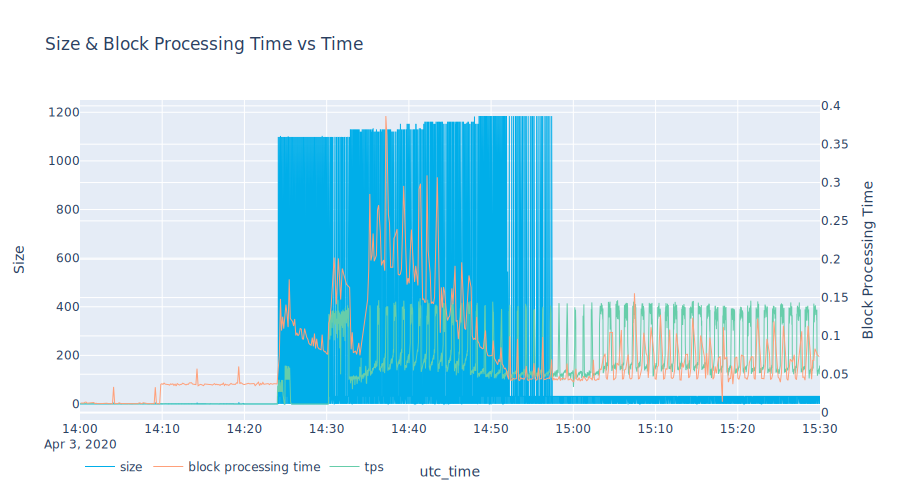

In [15]:
start_time = '2020-04-03 14:00:00.0'
end_time = '2020-04-03 15:30:00.0'
new_df = df[(df['time'] < end_time) & (df['time'] > start_time)]
trace1 = go.Scatter(
        x = new_df['time'],
        y = new_df['size'],
        mode = 'lines',
        line = dict(color = '#00AEE9',
                    width = 1),
        name = 'size'
    )
new_proposing = proposing[(proposing['time'] < end_time) & (proposing['time'] > start_time)]
trace2 = go.Scatter(
        x= new_proposing["time"],
        y= new_proposing["time_diff"],
        mode='lines',
        line = dict(color='#FFA07A', 
                    width=1),
        name = "block processing time",
        yaxis = 'y2'
    )
new_tps =  tps[(tps['time'] < end_time) & (tps['time'] > start_time)]
trace3 = go.Scatter(
        x= new_tps["time"],
        y= new_tps["tps"],
        mode='lines',
        line = dict(color='#66CDAA', 
                    width=1),
        name = "tps"
    )
    
data = [trace1, trace2, trace3]
layout = go.Layout(
            title = 'Size & Block Processing Time vs Time',
            xaxis_title="utc_time", 
            yaxis=dict(
                title='Size'
                ),
            yaxis2=dict(
                title='Block Processing Time',
                overlaying='y',
                side='right'
                ),
            legend_orientation="h", 
            legend=dict(x=0, y=-0.1)
        )
fig = go.Figure(data=data, layout=layout)
fig.show(renderer="svg",width=900, height=500)

### pick 5 minute during spamming, there are mainly 3 size group: less than 1 kb, 32 kb, 1.1 MB

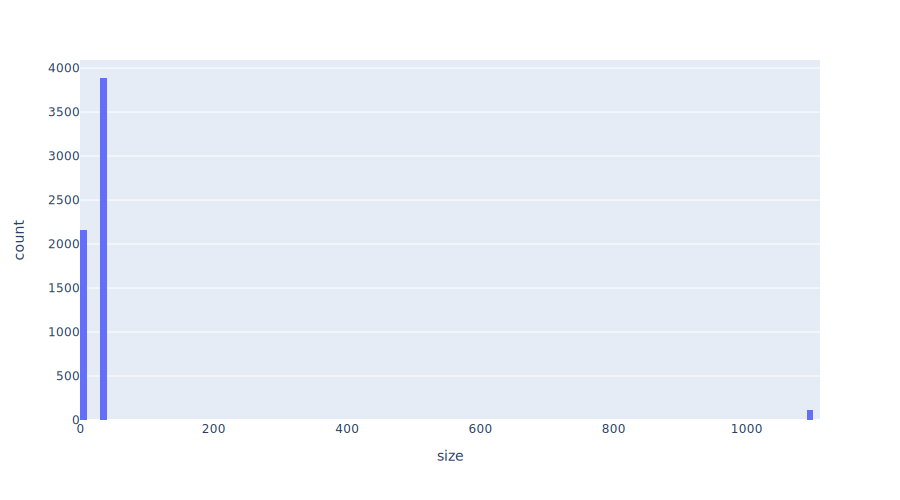

In [16]:
start_time = '2020-04-03 14:25:00.0'
end_time = '2020-04-03 14:30:00.0'
new = df[(df['time'] < end_time) & (df['time'] > start_time)]
fig = px.histogram(new, x="size")
fig.show(renderer="svg",width=900, height=500)

### Interval of more than 1MB

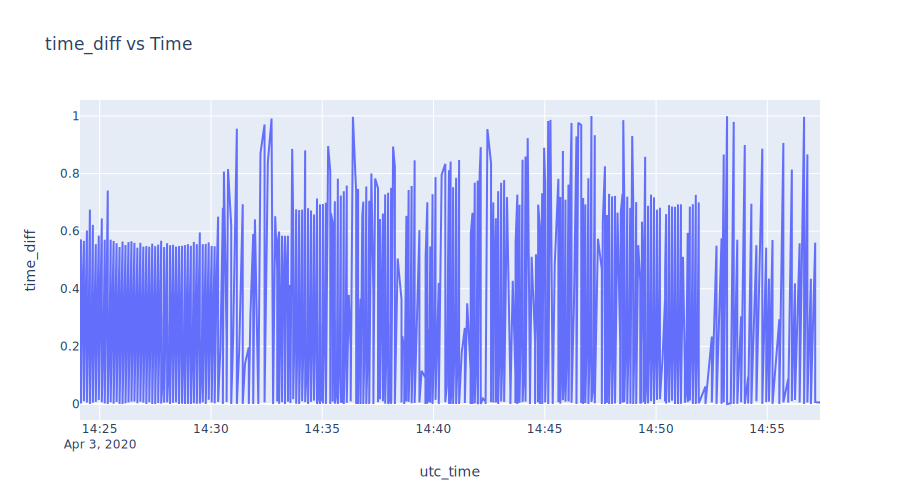

In [18]:
large_df = df.loc[df[df['size'] > 1024].index]
large_df['time_diff'] = large_df['time'].diff().dt.microseconds /1000000
fig = px.line(large_df, x="time", y="time_diff", title ='time_diff vs Time')
fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=0, y=-0.1))
fig.show(renderer="svg",width=900, height=500)